See [the documentation]() for instructions on installing Korg and making it talk to Python.

In [1]:
from julia import Korg
import matplotlib.pyplot as plt
import time

This notebook explains the basics of how to use Korg, but you can also see more detailed documentation for any function on the [documentation website](https://ajwheeler.github.io/Korg.jl/stable/API/), or by using Jupyter's built-in documentation viewer.  Uncomment the following cell to view detailed documentation for the synthesize function.

In [2]:
#?Korg.synthesize

## Read in a linelist (or use a built-in one)

First, load a linelist.  This one was created using VALD's "extractget_VALD_solar_linelistlar" feature. The [`read_linelist`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.read_linelist) function, which is automatically exported when you do `using Korg` loads a linelist file (VALD, Kurucz, and MOOG formats accepted), and returns a vector of `Korg.Line` objects.

If you don't have a linelist you want to use, Korg comes with a VALD extract-stellar linelist for the sun that you can use to get started, as well as the APOGEE DR17 linelist.

In [3]:
lines = Korg.read_linelist("linelist.vald", format="vald")
#lines = Korg.get_VALD_solar_linelist() # lines for the Sun from 3000 to 9000 Å
#lines = Korg.get_APOGEE_DR17_linelist() # if you want to do something in the infrared (this is for 15,000 Å - 17,000 Å)

We also need a model atmosphere.  `read_model_atmosphere` (also exported by Korg automatically) parses MARCS-format model atmosphere files, returning either a `Korg.PlanarAtmosphere` or `Korg.ShellAtmosphere` object.  

# Read in a model atmosphere (or interpolate one from the SDSS grid.)

Reading in a MARCS-format model atmosphere is as simple as calling the `read_model_atmosphere` function.

In [4]:
giant_atm = Korg.read_model_atmosphere("s6000_g+1.0_m0.5_t05_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod")

Korg also provides a function for interpolating model atmospheres from the [grid of MARCS atmospheres generated for the Sloan Digital Sky Survey](https://www.sdss4.org/dr17/irspec/apogee-libraries/).  This is convienient if you need atmospheres for specific stellar parameters, or if you don't want to download individual MARCS atmosphere files. 

The grid is a one-time download, which you can grab by running

In [5]:
# (uncomment first)
#Korg.download_atmosphere_archive()

Once you have the SDSS MARCS grid, you can interpolate new atmospheres with the `interpolate_marcs` function ([documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.interpolate_marcs)).  It takes 5 arguments: $T_\mathrm{eff}$, $\log g$, \[Fe/H\], \[$\alpha$/Fe\], and \[C/Fe\].

Unfortunately, acurately interpolating model atmospheres below $T_\mathrm{eff} \approx 4250~\mathrm{K}$, and interpolated atmospheres can contribute non-negligable error to synthetic spectra in this regime.  See [this github issue](https://github.com/ajwheeler/Korg.jl/issues/164) for details.

In [6]:
# this generates a model atmosphere for a dwarf with Teff = 5221 K and logg=4.32, [M/H] = -0.3, and [α/m] = 0.1
dwarf_atm = Korg.interpolate_marcs(5221, 4.32) # we could also provide abundance parameters for non-solar values

[ Info: loading the model atmosphere grid into memory. This will take a few seconds, but will only happen once per julia session.


**Important:** in general, you want the abundances of the model atmosphere to match those of the synthesis.  Below, I show to to do this easilly.

# Synthesizing a spectrum

Now we can synthesize a stellar spectrum, by passing the linelist and atmosphere to `synthesize` function, along with upper and lower wavelengths (in Å). Korg uses wavelengths *in vacuo*, but you can use [`Korg.air_to_vacuum`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.air_to_vacuum) and [`Korg.vacuum_to_air`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.vacuum_to_air) to convert back and forth. `synthesize` will also do this conversion automatically if you ask it to. See [the documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.synthesize) for a complete list of optional arguments.
`format_A_X()` returns the solar abundance pattern in the required format.

Julia is just-in-time compiled, which means that the first time in each session you call a method (e.g. `synthesize`, `read_linelist`, or `read_model_atmosphere`), the code will be compiled, which can take several seconds.  Here, we're using `time.process_time` to see how long each call to `synthesize` takes. The first call is kinda slow, with lots of time devoted to compilation. When we call it a second time, it's much faster, because no code needs to be compiled.

In [9]:
# run this cell again to see how much faster it is after precompilation.
t = time.process_time()
sol = Korg.synthesize(giant_atm, lines, Korg.format_A_X(0), 4000, 4030)
time.process_time() - t

0.46745999999999555

In [10]:
# run this cell again to see how much faster it is after precompilation.
t = time.process_time()
sol = Korg.synthesize(dwarf_atm, lines, Korg.format_A_X(0), 5000, 5030); 
time.process_time() - t

0.7109559999999959

`Korg.synthesize` returns a Julia `NamedTuple` containing the spectrum and other useful quantities.
`flux`, `cntm`, and `wavelengths` are exactly what they sound like, and can be accessed like this:

In [11]:
sol.flux
#sol.wavelengths
#sol.cntm

array([6.24767004e+14, 6.24783436e+14, 6.24693180e+14, ...,
       6.25462802e+14, 6.25538155e+14, 6.25607739e+14])

We can plot them with plt like this:

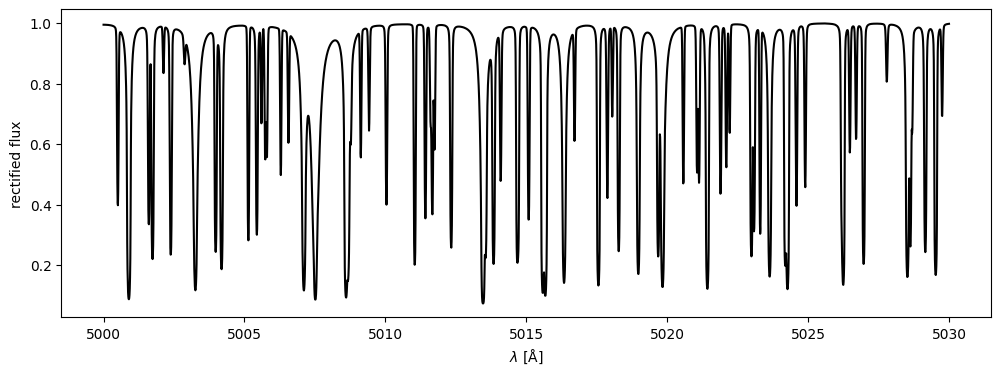

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(sol.wavelengths, sol.flux / sol.cntm, "k-")
plt.xlabel("$\lambda$ [Å]")
plt.ylabel("rectified flux");

## Specifying abundances

Let's synthesize spectra with varied abundances and take a look at the results.
Korg takes in a vector of abundances for all elements from H to U in $A(X)$ format. The `format_A_X` function provies an easy way to do this. The first argument specifies the default `[X/H]` abundance, the second lets you specify the default `[alpha/H]` abundance, and the third lets you specify individual abundances.


In [13]:
metal_poor_A_X = Korg.format_A_X(-0.5) # [M/H] = -1/2
alpha_rich_A_X = Korg.format_A_X(0, 0.5) # all [M/H] = 0, but [alpha/H] = 0.5]
Ni_enriched_A_X = Korg.format_A_X({"Ni": 1.0}) # all [M/H] = 0, except [Ni/H] = 1.0

Note that the resulting [M/H] for each vector is **not** the same at the default value you provided, unless you didn't set any other abundances.

In [14]:
print(Korg.get_metals_H(metal_poor_A_X))
print(Korg.get_metals_H(alpha_rich_A_X)) # particularly close to [α/H] because light alphas dominate the metal content
print(Korg.get_metals_H(Ni_enriched_A_X))

-0.5000009370397471
0.47053572460965576
0.00568615453494381


In order to make sure that the model atmosphere abundances match the synthesis abundances, we pass `A_X` vectors directly to `interpolate_marcs`.

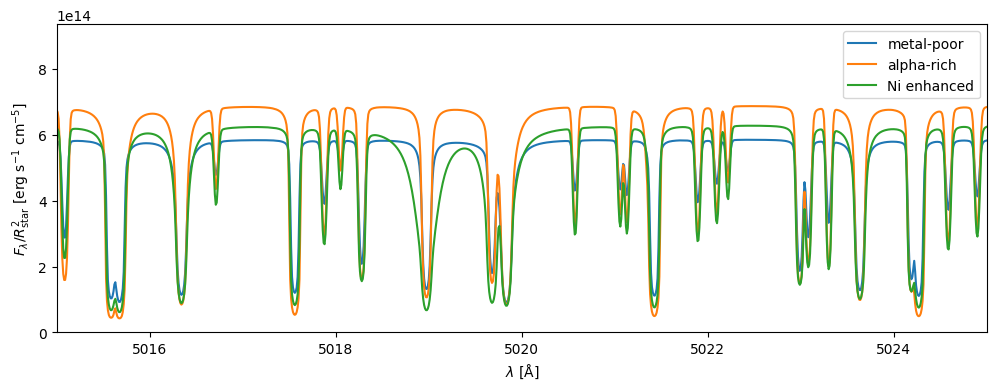

In [15]:
metal_poor_atm = Korg.interpolate_marcs(5221, 4.32, metal_poor_A_X)
metal_poor_sol = Korg.synthesize(metal_poor_atm, lines, metal_poor_A_X, 5015, 5025)

alpha_rich_sol = Korg.interpolate_marcs(5221, 4.32, alpha_rich_A_X)
alpha_rich_sol = Korg.synthesize(alpha_rich_sol, lines, alpha_rich_A_X, 5015, 5025)

Ni_enriched_atm = Korg.interpolate_marcs(5221, 4.32, Ni_enriched_A_X)
Ni_enriched_sol = Korg.synthesize(Ni_enriched_atm, lines, Ni_enriched_A_X, 5015, 5025)

plt.figure(figsize=(12, 4))
plt.plot(metal_poor_sol.wavelengths, metal_poor_sol.flux, label="metal-poor")
plt.plot(alpha_rich_sol.wavelengths, alpha_rich_sol.flux, label="alpha-rich")
plt.plot(Ni_enriched_sol.wavelengths, Ni_enriched_sol.flux, label="Ni enhanced")

plt.xlabel("$\lambda$ [Å]")
plt.ylabel("$F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]")
plt.xlim(5015, 5025)
plt.ylim(0, plt.ylim()[1]*1.3) # make a little room on top for the legend
plt.legend();

## Other data returned by `synthesize`

`sol.alpha` is a matrix containing the absorption coefficient, $\alpha$ at each wavelength and atmospheric layer.  We can plot $\alpha$ as a function of wavelength like this.

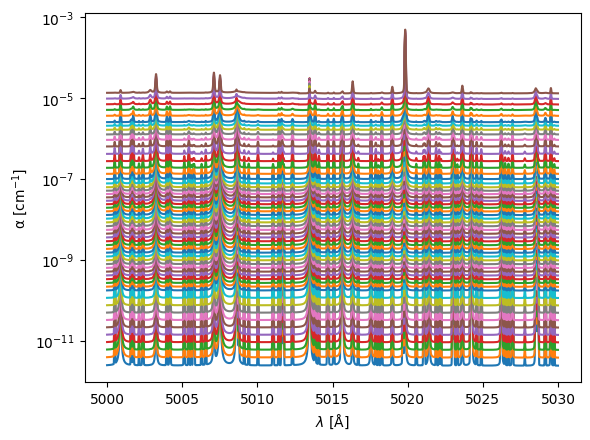

In [16]:
plt.plot(sol.wavelengths, sol.alpha.transpose())
plt.yscale("log")
plt.xlabel("$\lambda$ [Å]")
plt.ylabel("α [cm$^{-1}$]");